<a href="https://colab.research.google.com/github/Txlu-OG/AI-Project/blob/main/AI_Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 5: Basic Natural Language Processing with Unsupervised Learning
Author: Adedamola Ogundipe

Course Project – NLP & Unsupervised Learning

This notebook implements a workflow pipeline for:

Text data preparation using the 20 Newsgroups dataset
Text preprocessing (tokenization, stopword & punctuation removal)
Text representation with Bag-of-Words and TF–IDF
Basic embeddings-style dense document representation
Unsupervised learning with K-Means clustering
Cluster interpretation and evaluation (silhouette score)
Predicting clusters for new, unseen documents
Visualization of clusters using dimensionality reduction

In [1]:
# Import All the required Libraries
import re
import string
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

In [2]:
# Load 20 Newsgroups dataset (train subset)
newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
texts = newsgroups.data
targets = newsgroups.target
target_names = newsgroups.target_names

print('Number of documents:', len(texts))
print('Number of categories:', len(target_names))
print('Example categories:', target_names[:5])

Number of documents: 11314
Number of categories: 20
Example categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']


In [3]:
stop_words = ENGLISH_STOP_WORDS

def tokenize(text):
    """Simple tokenizer: lowercase, keep alphabetic tokens of length >= 2."""
    text = text.lower()
    tokens = re.findall(r"[a-zA-Z]+", text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    return tokens

def preprocess(text):
    tokens = tokenize(text)
    return ' '.join(tokens)

# This may take a little time on full dataset
processed_texts = [preprocess(doc) for doc in texts]
print('Preprocessing complete. Example:')
print('Original:', texts[0][:300].replace('\n', ' '))
print('\nProcessed:', processed_texts[0][:300])

Preprocessing complete. Example:
Original: I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s/ early 70s. It was called a Bricklin. The doors were really small. In addition, the front bumper was separate from the rest of the body. This is  all I k

Processed: wondering enlighten car saw day door sports car looked late early called bricklin doors really small addition bumper separate rest body know tellme model engine specs years production car history info funky looking car mail


In [4]:
bow_vectorizer = CountVectorizer(max_features=5000)
X_bow = bow_vectorizer.fit_transform(processed_texts)

print('BoW matrix shape:', X_bow.shape)

BoW matrix shape: (11314, 5000)


In [5]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(processed_texts)

print('TF–IDF matrix shape:', X_tfidf.shape)

TF–IDF matrix shape: (11314, 5000)


In [6]:
n_components = 100  # dimensionality of dense representation
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

print('SVD-based dense representation shape:', X_svd.shape)

SVD-based dense representation shape: (11314, 100)


In [7]:
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_tfidf)

print('K-Means clustering complete.')

K-Means clustering complete.


In [8]:
terms = tfidf_vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(min(n_clusters, 10)):
    print(f'Cluster {i}')
    top_terms = [terms[ind] for ind in order_centroids[i, :15]]
    print('Top terms:', ', '.join(top_terms))
    print('-' * 80)

Cluster 0
Top terms: bike, ride, bikes, dod, riding, motorcycle, just, like, honda, rear, miles, good, helmet, dog, right
--------------------------------------------------------------------------------
Cluster 1
Top terms: car, cars, engine, dealer, like, good, new, speed, just, ford, miles, driving, don, mph, price
--------------------------------------------------------------------------------
Cluster 2
Top terms: sale, offer, shipping, condition, price, asking, new, sell, email, interested, excellent, best, obo, edu, cd
--------------------------------------------------------------------------------
Cluster 3
Top terms: key, encryption, chip, clipper, keys, escrow, government, nsa, algorithm, secure, use, encrypted, phone, des, public
--------------------------------------------------------------------------------
Cluster 4
Top terms: thanks, mail, advance, know, does, hi, info, address, looking, help, email, information, appreciated, anybody, send
---------------------------------

In [9]:
# Silhouette score on a sample for efficiency
sample_size = 3000 if X_tfidf.shape[0] > 3000 else X_tfidf.shape[0]

from sklearn.utils import resample
X_sample, labels_sample = resample(X_tfidf, cluster_labels,
                                   n_samples=sample_size,
                                   random_state=42)

sil_score = silhouette_score(X_sample, labels_sample)
print('Silhouette score (sample):', sil_score)

Silhouette score (sample): 0.011921920195241624


In [10]:
def predict_cluster(text):
    processed = preprocess(text)
    vec = tfidf_vectorizer.transform([processed])
    cluster = kmeans.predict(vec)[0]
    return cluster

new_doc = "NASA announced a new mission to explore Mars with robotic probes."
predicted_cluster = predict_cluster(new_doc)
print('New document:', new_doc)
print('Predicted cluster:', predicted_cluster)

New document: NASA announced a new mission to explore Mars with robotic probes.
Predicted cluster: 14


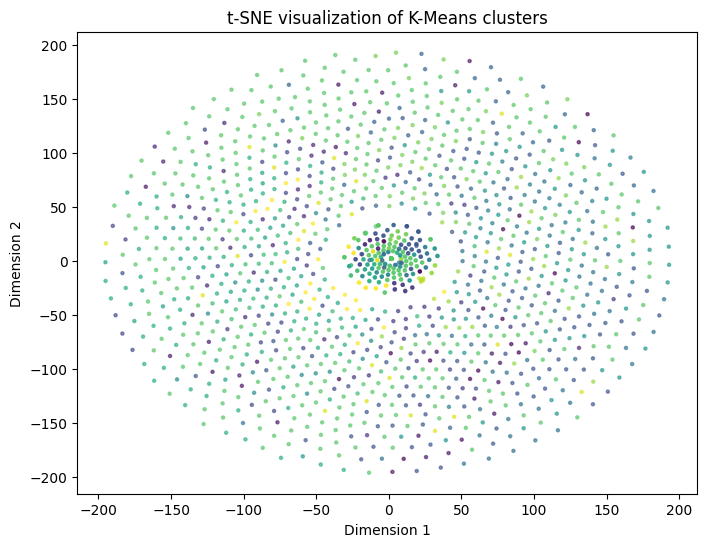

In [11]:
# Use a subset for visualization to keep it fast
max_points = 1500
if X_tfidf.shape[0] > max_points:
    X_vis, labels_vis = resample(X_tfidf, cluster_labels,
                                 n_samples=max_points,
                                 random_state=42)
else:
    X_vis, labels_vis = X_tfidf, cluster_labels

tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_2d = tsne.fit_transform(X_vis.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=5, alpha=0.6, c=labels_vis)
plt.title('t-SNE visualization of K-Means clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()